In [1]:
import requests
import pandas as pd
import tqdm
import bs4
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
from pathlib import Path
import time

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

In [3]:
from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs

In [4]:
path = Path('pbp_data/2020-21.csv')
data_frame = None
if path.exists():
    data_frame = pd.read_csv(str(path))

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data_frame.loc[:, 'GAME_ID'] = [f"00{item}" for item in data_frame.GAME_ID.astype(str)]

## All seasons pbp

In [4]:
#season = '2020-21'

seasons = [f"{season}-{str(season+1)[-2:]}" for season in range(2010, 2015)]
for season in seasons:
    print(f"Processing {season}")
    pbp_dfs = []
    game_finder = LeagueGameFinder(season_nullable=season, league_id_nullable='00', season_type_nullable='Regular Season')
    df = game_finder.get_data_frames()[0]
    game_ids = df.GAME_ID.unique()
    for game_id in tqdm.tqdm(game_ids):
        while True:
            try:
                pbp_df = PlayByPlayV2(game_id=game_id).get_data_frames()[0]
                break
            except Exception as e:
                print(f"Error occured: {e}, Game ID: {game_id}, retrying")
                time.sleep(0.1)
        pbp_dfs.append(pbp_df)
        time.sleep(0.25)
    cur_ful = pd.concat(pbp_dfs)
    cur_ful.to_csv(f'pbp_data/{season}.csv', index=False)


Processing 2010-11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [18:21<00:00,  1.12it/s]


Processing 2011-12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [15:37<00:00,  1.06it/s]


Processing 2012-13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1229/1229 [19:06<00:00,  1.07it/s]


Processing 2013-14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [19:15<00:00,  1.06it/s]


Processing 2014-15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [19:50<00:00,  1.03it/s]


## Cur season pbp

In [6]:
season = '2020-21'
print(f"Processing {season}")
pbp_dfs = []
game_finder = LeagueGameFinder(season_nullable=season, league_id_nullable='00', season_type_nullable='Regular Season')
df = game_finder.get_data_frames()[0]
game_ids = df.GAME_ID.unique()
for game_id in tqdm.tqdm(game_ids):
    if data_frame is not None and game_id in data_frame.GAME_ID.tolist():
        continue
    while True:
        try:
            pbp_df = PlayByPlayV2(game_id=game_id).get_data_frames()[0]
            break
        except Exception as e:
            print(f"Error occured: {e}, Game ID: {game_id}, retrying")
            time.sleep(0.1)
    pbp_dfs.append(pbp_df)
    time.sleep(0.25)
full_df = pd.concat([data_frame] + pbp_dfs)

Processing 2020-21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [01:06<00:00, 10.21it/s]
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
game_finder_df = df

In [7]:
full_df = pd.concat([data_frame] + pbp_dfs)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in full_df.PCTIMESTRING.tolist()]

In [9]:
full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})

In [10]:
full_df.to_csv('pbp_data/2020-21.csv', index=False)

In [80]:
full_df = pd.read_csv('pbp_data/2020-21.csv')

In [81]:
full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

## Sub notes

Player1 -> substituted out

Player2 -> Substituted in

In [105]:
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in full_df.PCTIMESTRING.tolist()]

In [65]:
cur_season_games = game_finder_df.loc[(game_finder_df.TEAM_ABBREVIATION == "LAL") & (game_finder_df.SEASON_ID == "22020")]

In [66]:
lal_games = full_df.loc[full_df.GAME_ID.isin(cur_season_games.GAME_ID)]

In [67]:
player_id = find_players_by_full_name("Anthony Davis")[0]
lakers_id = find_teams_by_full_name("Los Angeles Lakers")[0]

In [68]:
player_id = player_id['id']
lakers_id = lakers_id['id']

In [69]:
lakers_subs = lal_games.loc[((lal_games.EVENTMSGTYPE == 8) & (lal_games.PLAYER1_TEAM_ID == lakers_id)) | (lal_games.EVENTMSGTYPE == 12) | (lal_games.EVENTMSGTYPE == 13)]

In [70]:
davis_subs = lakers_subs.loc[(
    ( (lakers_subs.EVENTMSGTYPE == 8) & ((lakers_subs.PLAYER1_ID == player_id) | (lakers_subs.PLAYER2_ID == player_id))) |
    ( lakers_subs.EVENTMSGTYPE == 13) |
    ( lakers_subs.EVENTMSGTYPE == 12))]

## On Off Finder

In [71]:
SUB_OUT = "SUB_OUT"
SUB_IN = "SUB_IN"
PERIOD_END = "PERIOD_END"

def filter_plays(
    df,
    previous_seconds: int,
    current_seconds: int,
    previous_eventnum: int,
    current_eventnum: int,
    prev_type: str,
    cur_type: str,
    target_player_id,
    stint_number: int,
    cur_period: int
):
    if cur_type == SUB_IN:
        return None
    
    """if previous_eventnum is None:
        indexed_df = df.loc[df.EVENTNUM <= current_eventnum]
    else:
        indexed_df = df.loc[(df.EVENTNUM > previous_eventnum) & (df.EVENTNUM <= current_eventnum)]"""
    indexed_df = df.loc[df.PERIOD == cur_period]
    if previous_seconds is None:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds)]
    else:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds) & (indexed_df.PCTIMESECONDS > previous_seconds)]
    subset_without_subs = indexed_df.loc[indexed_df.EVENTMSGTYPE != 8]
    if any(subset_without_subs.PLAYER1_ID == target_player_id) or \
        any(subset_without_subs.PLAYER2_ID == target_player_id) or \
        any(subset_without_subs.PLAYER3_ID == target_player_id):
        indexed_df.loc[:, 'STINT_NUM'] = stint_number
        return indexed_df
    return None

def filter_off_court(
    df,
    previous_seconds: int,
    current_seconds: int,
    previous_eventnum: int,
    current_eventnum: int,
    prev_type: str,
    cur_type: str,
    target_player_id,
    cur_period: int
):
    if cur_type == SUB_OUT:
        return None
    
    """if previous_eventnum is None:
        indexed_df = df.loc[df.EVENTNUM < current_eventnum]
    else:
        indexed_df = df.loc[(df.EVENTNUM > previous_eventnum) & (df.EVENTNUM < current_eventnum)]"""
    indexed_df = df.loc[df.PERIOD == cur_period]
    if previous_seconds is None:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds)]
    else:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds) & (indexed_df.PCTIMESECONDS > previous_seconds)]
    subset_without_subs = indexed_df.loc[indexed_df.EVENTMSGTYPE != 8]
    if all(subset_without_subs.PLAYER1_ID != target_player_id) and \
        all(subset_without_subs.PLAYER2_ID != target_player_id) and \
        all(subset_without_subs.PLAYER3_ID != target_player_id):
        return indexed_df
    return None

In [74]:
final_dfs = []
final_off_dfs = []
pgl = PlayerGameLogs(player_id_nullable=player_id, season_nullable='2020-21', measure_type_player_game_logs_nullable='Base')
pgl = pgl.get_data_frames()[0]
stint_number = 0
for game_id in tqdm.tqdm(pgl.GAME_ID.unique()):
    cur_subs = davis_subs.loc[davis_subs.GAME_ID == game_id]
    key_events = cur_subs.loc[:, ["GAME_ID", "EVENTMSGTYPE", "EVENTNUM", "PERIOD", "PCTIMESTRING", "PLAYER1_ID", "PLAYER2_ID", "PCTIMESECONDS"]]

    current_game = full_df.loc[full_df.GAME_ID == game_id]

    previous_eventnum = None
    previous_seconds = 0
    prev_type = None
    target_dfs = []
    target_off_dfs = []

    for i in range(len(key_events)):
        current_event = key_events.iloc[i]
        ev_type = PERIOD_END
        if current_event.EVENTMSGTYPE == 8 and current_event.PLAYER1_ID == player_id:
            ev_type = SUB_OUT
        elif current_event.EVENTMSGTYPE == 8 and current_event.PLAYER2_ID == player_id:
            ev_type = SUB_IN
        elif current_event.EVENTMSGTYPE == 12:
            previous_eventnum = current_event.EVENTNUM
            previous_seconds = current_event.PCTIMESECONDS
            prev_type = ev_type
            continue
        filtered_df = filter_plays(
            df=current_game, 
            previous_seconds=previous_seconds,
            previous_eventnum=previous_eventnum,
            current_seconds=current_event.PCTIMESECONDS,
            current_eventnum=current_event.EVENTNUM,
            prev_type=prev_type,
            cur_type=ev_type,
            target_player_id=player_id,
            stint_number=stint_number,
            cur_period=current_event.PERIOD
        )
        if filtered_df is not None:
            stint_number += 1
            target_dfs.append(filtered_df)
        
        off_court_filter = filter_off_court(
            df=current_game, 
            previous_seconds=previous_seconds,
            previous_eventnum=previous_eventnum,
            current_seconds=current_event.PCTIMESECONDS,
            current_eventnum=current_event.EVENTNUM,
            cur_period=current_event.PERIOD,
            prev_type=prev_type,
            cur_type=ev_type,
            target_player_id=player_id
        )
        if off_court_filter is not None:
            target_off_dfs.append(off_court_filter)
        previous_eventnum = current_event.EVENTNUM
        previous_seconds = current_event.PCTIMESECONDS
        prev_type = ev_type

    if len(target_dfs) == 0 or game_id == "0021900633":
        continue
    final_dfs.append(pd.concat(target_dfs))
    final_off_dfs.append(pd.concat(target_off_dfs))

  0%|                                                                                                                                                                                        | 0/19 [00:00<?, ?it/s]c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 475.14it/s]


In [75]:
current_game

,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,PERSON1TYPE,...,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING


### Calculation

In [254]:
davis_on = pd.concat(final_dfs)

In [255]:
davis_off = pd.concat(final_off_dfs)

In [258]:
stints = list(davis_on.STINT_NUM.unique())

In [257]:
test_stint = davis_on.loc[davis_on.STINT_NUM == 21]

In [201]:
stint_start = test_stint.PCTIMESECONDS.min()
stint_end = test_stint.PCTIMESECONDS.max()

In [207]:
test_shots = test_stint.loc[((test_stint.EVENTMSGTYPE == 1) | (test_stint.EVENTMSGTYPE == 2)) & (test_stint.PLAYER1_ID == player_id)]

In [259]:
from collections import Counter

In [270]:

made_shots = Counter()
all_shots = Counter()


for stint in stints:
    cur_stint = davis_on.loc[davis_on.STINT_NUM == stint]
    stint_start = cur_stint.PCTIMESECONDS.min()
    stint_end = cur_stint.PCTIMESECONDS.max()
    cur_shots = cur_stint.loc[((cur_stint.EVENTMSGTYPE == 1) | (cur_stint.EVENTMSGTYPE == 2)) & (cur_stint.PLAYER1_ID == player_id)]
    for i in range(len(cur_shots)):
        cur_shot = cur_shots.iloc[i]
        time_of_shot = cur_shot.PCTIMESECONDS - stint_start
        # Shot was taken in a stint with < bucket
        bucket = (time_of_shot // 60) + 1
        if cur_shot.EVENTMSGTYPE == 1:
            made_shots[bucket] += 1
            
        all_shots[bucket] += 1


In [276]:
for key in sorted(all_shots):
    print(f"Efficiency when AD is {key-1}-{key} minute on court: {made_shots[key]}/{all_shots[key]} ({made_shots[key]/all_shots[key] * 100:.1f}%)")

Efficiency when AD is 0-1 minute on court: 21/42 (50.0%)
Efficiency when AD is 1-2 minute on court: 11/27 (40.7%)
Efficiency when AD is 2-3 minute on court: 18/26 (69.2%)
Efficiency when AD is 3-4 minute on court: 12/21 (57.1%)
Efficiency when AD is 4-5 minute on court: 17/28 (60.7%)
Efficiency when AD is 5-6 minute on court: 18/30 (60.0%)
Efficiency when AD is 6-7 minute on court: 9/24 (37.5%)
Efficiency when AD is 7-8 minute on court: 11/18 (61.1%)
Efficiency when AD is 8-9 minute on court: 7/19 (36.8%)
Efficiency when AD is 9-10 minute on court: 4/9 (44.4%)
Efficiency when AD is 10-11 minute on court: 3/7 (42.9%)
Efficiency when AD is 11-12 minute on court: 4/7 (57.1%)


In [278]:

first_quartal = []

for key in [3, 6, 9, 12]:
    fgm = 0
    fga = 0
    for item in range(key-3+1, key+1):
        fgm += made_shots[key]
        fga += all_shots[key]
    print(f"Efficiency when AD is {key-3}-{key} minutes on court: {fgm}/{fga} ({fgm/fga * 100:.1f}%)")

Efficiency when AD is 0-3 minutes on court: 54/78 (69.2%)
Efficiency when AD is 3-6 minutes on court: 54/90 (60.0%)
Efficiency when AD is 6-9 minutes on court: 21/57 (36.8%)
Efficiency when AD is 9-12 minutes on court: 12/21 (57.1%)


### Functions all

In [4]:
def get_game_schedule_for_season(season):
    game_finder = LeagueGameFinder(season_nullable=season, league_id_nullable='00', season_type_nullable='Regular Season')
    df = game_finder.get_data_frames()[0]
    return df

In [5]:
def get_player_substitutions(pbp_df, player_id, game_schedule_df):
    """target_games = game_schedule_df.loc[game_schedule_df.TEAM_ID == team_id]
    team_games = pbp_df.loc[pbp_df.GAME_ID.isin(target_games.GAME_ID)]
    team_subs = team_games.loc[(
        (team_games.EVENTMSGTYPE == 8) & (team_games.PLAYER1_TEAM_ID == team_id)) 
    | (team_games.EVENTMSGTYPE == 12) 
    | (team_games.EVENTMSGTYPE == 13)]
    """
    player_subs = pbp_df.loc[(
        ( (pbp_df.EVENTMSGTYPE == 8) & ((pbp_df.PLAYER1_ID == player_id) | (pbp_df.PLAYER2_ID == player_id))) |
        ( pbp_df.EVENTMSGTYPE == 13) |
        ( pbp_df.EVENTMSGTYPE == 12))]
    return player_subs

In [6]:
SUB_OUT = "SUB_OUT"
SUB_IN = "SUB_IN"
PERIOD_END = "PERIOD_END"

def filter_plays(
    df,
    previous_seconds: int,
    current_seconds: int,
    previous_eventnum: int,
    current_eventnum: int,
    prev_type: str,
    cur_type: str,
    target_player_id,
    stint_number: int,
    cur_period: int
):
    if cur_type == SUB_IN:
        return None
    
    """if previous_eventnum is None:
        indexed_df = df.loc[df.EVENTNUM <= current_eventnum]
    else:
        indexed_df = df.loc[(df.EVENTNUM > previous_eventnum) & (df.EVENTNUM <= current_eventnum)]"""
    indexed_df = df.loc[df.PERIOD == cur_period]
    if previous_seconds is None:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds)]
    else:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds) & (indexed_df.PCTIMESECONDS > previous_seconds)]
    subset_without_subs = indexed_df.loc[indexed_df.EVENTMSGTYPE != 8]
    if any(subset_without_subs.PLAYER1_ID == target_player_id) or \
        any(subset_without_subs.PLAYER2_ID == target_player_id) or \
        any(subset_without_subs.PLAYER3_ID == target_player_id):
        indexed_df.loc[:, 'STINT_NUM'] = stint_number
        return indexed_df
    return None

def filter_off_court(
    df,
    previous_seconds: int,
    current_seconds: int,
    previous_eventnum: int,
    current_eventnum: int,
    prev_type: str,
    cur_type: str,
    target_player_id,
    cur_period: int
):
    if cur_type == SUB_OUT:
        return None
    
    """if previous_eventnum is None:
        indexed_df = df.loc[df.EVENTNUM < current_eventnum]
    else:
        indexed_df = df.loc[(df.EVENTNUM > previous_eventnum) & (df.EVENTNUM < current_eventnum)]"""
    indexed_df = df.loc[df.PERIOD == cur_period]
    if previous_seconds is None:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds)]
    else:
        indexed_df = indexed_df.loc[(indexed_df.PCTIMESECONDS <= current_seconds) & (indexed_df.PCTIMESECONDS > previous_seconds)]
    subset_without_subs = indexed_df.loc[indexed_df.EVENTMSGTYPE != 8]
    if all(subset_without_subs.PLAYER1_ID != target_player_id) and \
        all(subset_without_subs.PLAYER2_ID != target_player_id) and \
        all(subset_without_subs.PLAYER3_ID != target_player_id):
        return indexed_df
    return None

In [7]:

def get_on_off_data(player_id, season, player_subs, full_df):
    final_dfs = []
    final_off_dfs = []
    pgl = PlayerGameLogs(player_id_nullable=player_id, season_nullable=season, measure_type_player_game_logs_nullable='Base')
    pgl = pgl.get_data_frames()[0]
    stint_number = 0
    for game_id in tqdm.tqdm(pgl.GAME_ID.unique()):
        cur_subs = player_subs.loc[player_subs.GAME_ID == game_id]
        key_events = cur_subs.loc[:, ["GAME_ID", "EVENTMSGTYPE", "EVENTNUM", "PERIOD", "PCTIMESTRING", "PLAYER1_ID", "PLAYER2_ID", "PCTIMESECONDS"]]

        current_game = full_df.loc[full_df.GAME_ID == game_id]
        previous_eventnum = None
        previous_seconds = 0
        prev_type = None
        target_dfs = []
        target_off_dfs = []
        for i in range(len(key_events)):
            current_event = key_events.iloc[i]
            ev_type = PERIOD_END
            if current_event.EVENTMSGTYPE == 8 and current_event.PLAYER1_ID == player_id:
                ev_type = SUB_OUT
            elif current_event.EVENTMSGTYPE == 8 and current_event.PLAYER2_ID == player_id:
                ev_type = SUB_IN
            elif current_event.EVENTMSGTYPE == 12:
                previous_eventnum = current_event.EVENTNUM
                previous_seconds = current_event.PCTIMESECONDS
                prev_type = ev_type
                continue
            filtered_df = filter_plays(
                df=current_game, 
                previous_seconds=previous_seconds,
                previous_eventnum=previous_eventnum,
                current_seconds=current_event.PCTIMESECONDS,
                current_eventnum=current_event.EVENTNUM,
                prev_type=prev_type,
                cur_type=ev_type,
                target_player_id=player_id,
                stint_number=stint_number,
                cur_period=current_event.PERIOD
            )
            if filtered_df is not None:
                stint_number += 1
                target_dfs.append(filtered_df)

            off_court_filter = filter_off_court(
                df=current_game, 
                previous_seconds=previous_seconds,
                previous_eventnum=previous_eventnum,
                current_seconds=current_event.PCTIMESECONDS,
                current_eventnum=current_event.EVENTNUM,
                cur_period=current_event.PERIOD,
                prev_type=prev_type,
                cur_type=ev_type,
                target_player_id=player_id
            )
            if off_court_filter is not None:
                target_off_dfs.append(off_court_filter)
            previous_eventnum = current_event.EVENTNUM
            previous_seconds = current_event.PCTIMESECONDS
            prev_type = ev_type

        if len(target_dfs) == 0:
            continue
        final_dfs.append(pd.concat(target_dfs))
        if len(target_off_dfs) == 0:
            continue
        final_off_dfs.append(pd.concat(target_off_dfs))
    player_on = pd.concat(final_dfs)
    player_off = pd.concat(final_off_dfs)
    return player_on, player_off

In [8]:
from collections import Counter


def get_shots(player_on):
    made_shots = Counter()
    all_shots = Counter()

    stints = list(player_on.STINT_NUM.unique())
    for stint in stints:
        cur_stint = player_on.loc[player_on.STINT_NUM == stint]
        stint_start = cur_stint.PCTIMESECONDS.min()
        stint_end = cur_stint.PCTIMESECONDS.max()
        cur_shots = cur_stint.loc[((cur_stint.EVENTMSGTYPE == 1) | (cur_stint.EVENTMSGTYPE == 2)) & (cur_stint.PLAYER1_ID == player_id)]
        cur_shots = cur_shots.drop_duplicates()
        for i in range(len(cur_shots)):
            cur_shot = cur_shots.iloc[i]
            time_of_shot = cur_shot.PCTIMESECONDS - stint_start
            # Shot was taken in a stint with < bucket
            bucket = (time_of_shot // 60) + 1
            if cur_shot.EVENTMSGTYPE == 1:
                made_shots[bucket] += 1

            all_shots[bucket] += 1
    return made_shots, all_shots

In [9]:
def print_efficiency(made_shots, all_shots, player_name):
    #for key in sorted(all_shots):
    #    print(f"Efficiency when {player_name} is {key-1}-{key} minute on court: {made_shots[key]}/{all_shots[key]} ({made_shots[key]/all_shots[key] * 100:.1f}%)")

    #print()
    first_quartal = []

    ret_val = []
    for key in [3, 6, 9, 12]:
        fgm = 0
        fga = 0
        for item in range(key-3+1, key+1):
            fgm += made_shots[item]
            fga += all_shots[item]
        ret_val.append(f"Efficiency when {player_name} is {key-3}-{key} minutes on court: {fgm}/{fga} ({fgm/fga * 100:.1f}%)")
    return "\n".join(ret_val)

### Checking data

In [92]:
player_name = "Anthony Davis"
team_name = "Los Angeles Lakers"
season = '2020-21'
player_id = find_players_by_full_name(player_name)[0]['id']
team_id = find_teams_by_full_name(team_name)[0]['id']

In [10]:
season = '2019-20'
last_df = pd.read_csv(f'pbp_data/{season}.csv')
last_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in last_df.GAME_ID.astype(str)]
last_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in last_df.PCTIMESTRING.tolist()]

In [11]:
last_df = last_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})

In [12]:
full_df = last_df

In [93]:
last_schedule = get_game_schedule_for_season(season=season)

In [94]:
player_subs = get_player_substitutions(pbp_df=full_df, player_id=player_id, game_schedule_df=last_schedule)

In [95]:
player_on, player_off = get_on_off_data(player_id=player_id, season=season, player_subs=player_subs, full_df=full_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 15.29it/s]


In [96]:
made_shots, all_shots = get_shots(player_on=player_on)

In [178]:
print(print_efficiency(made_shots=made_shots, all_shots=all_shots, player_name=player_name))

Efficiency when Anthony Davis is 0-3 minutes on court: 60/117 (51.3%)
Efficiency when Anthony Davis is 3-6 minutes on court: 55/92 (59.8%)
Efficiency when Anthony Davis is 6-9 minutes on court: 37/76 (48.7%)
Efficiency when Anthony Davis is 9-12 minutes on court: 13/30 (43.3%)


### Plotting shot chart WITH and WITHOUT player

In [13]:
player_name = "Anthony Davis"
team_name = "Los Angeles Lakers"
season = '2019-20'
player_id = find_players_by_full_name(player_name)[0]['id']

last_schedule = get_game_schedule_for_season(season=season)
player_subs = get_player_substitutions(pbp_df=full_df, player_id=player_id, game_schedule_df=last_schedule)
player_on, player_off = get_on_off_data(player_id=player_id, season=season, player_subs=player_subs, full_df=full_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:04<00:00, 12.79it/s]


In [14]:
pgl = PlayerGameLogs(player_id_nullable=player_id, season_nullable=season, measure_type_player_game_logs_nullable='Base')

In [15]:
pgl.get_data_frames()[0]

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK
0,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901296,2020-08-10T00:00:00,LAL vs. DEN,W,...,4,22,33,2,24,25,11,20,30,1
1,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901282,2020-08-08T00:00:00,LAL @ IND,L,...,13,22,1,2,55,61,61,59,30,1
2,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901273,2020-08-06T00:00:00,LAL @ HOU,L,...,48,42,1,2,12,51,52,57,1,1
3,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901265,2020-08-05T00:00:00,LAL vs. OKC,L,...,48,58,1,59,49,59,59,61,30,1
4,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901255,2020-08-03T00:00:00,LAL @ UTA,W,...,4,42,33,32,3,3,23,3,1,1
5,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901243,2020-08-01T00:00:00,LAL @ TOR,L,...,30,12,33,32,42,57,60,51,30,1
6,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021901232,2020-07-30T00:00:00,LAL vs. LAC,W,...,48,58,54,50,3,10,42,41,30,1
7,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021900968,2020-03-10T00:00:00,LAL vs. BKN,L,...,48,42,1,50,24,30,47,49,30,1
8,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021900948,2020-03-08T00:00:00,LAL @ LAC,W,...,13,42,1,59,12,20,12,33,30,1
9,2019-20,203076,Anthony Davis,1610612747,LAL,Los Angeles Lakers,0021900939,2020-03-06T00:00:00,LAL vs. MIL,W,...,48,22,1,50,12,20,21,44,30,1


In [115]:
lebron_id = find_players_by_full_name("LeBron James")[0]['id']

In [116]:
last_schedule = get_game_schedule_for_season(season=season)
player_subs = get_player_substitutions(pbp_df=full_df, player_id=lebron_id, game_schedule_df=last_schedule)
lebron_on, lebron_off = get_on_off_data(player_id=lebron_id, season=season, player_subs=player_subs, full_df=full_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 12.56it/s]


In [127]:
#davis_wo_lebron = 
ad_lebron = pd.merge(left=player_on, right=lebron_on, on=('GAME_ID', 'EVENTNUM'), suffixes=('', '_other'))
ad_wo_lebron = pd.merge(left=player_on, right=lebron_off, on=('GAME_ID', 'EVENTNUM'), suffixes=('', '_other'))

In [165]:
ad_shots_lebron = ad_lebron.loc[((ad_lebron.EVENTMSGTYPE == 1) | (ad_lebron.EVENTMSGTYPE == 2)) & (ad_lebron.PLAYER1_ID == player_id)]

In [166]:
ad_shots_no_lebron = ad_wo_lebron.loc[((ad_lebron.EVENTMSGTYPE == 1) | (ad_lebron.EVENTMSGTYPE == 2)) & (ad_wo_lebron.PLAYER1_ID == player_id)]

In [167]:
target_columns = [
    'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM', 'GAME_ID',
       'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESECONDS',
       'PCTIMESTRING', 'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION',
       'PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION',
       'PLAYER2_TEAM_CITY', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION',
       'PLAYER3_TEAM_CITY', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME',
       'SCORE', 'SCOREMARGIN', 'VIDEO_AVAILABLE_FLAG', 'VISITORDESCRIPTION',
       'WCTIMESTRING',
]

In [168]:
ad_shots_no_lebron = ad_shots_no_lebron.loc[:, target_columns]

In [169]:
ad_shots_lebron = ad_shots_lebron.loc[:, target_columns]

### Plotting Shot Chart

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO

from PIL import Image

In [136]:
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [154]:
shots_df = ShotChartDetail(player_id=0, team_id=0, season_nullable='2020-21', context_measure_simple='FGA')

In [155]:
shots_df = shots_df.get_data_frames()[0]

In [156]:
plt.style.use('fivethirtyeight')

In [157]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [158]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [159]:
def plot_raw_shotchart_dark(
        data_frame,
        title,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False,
        plot_image=False,
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    #data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    if plot_attempts:
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if df_by_zone_median.iloc[index].name not in text_location_mapping:
                continue
            x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
            if zone_shots_attempted < 3:
                continue
            ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, fontsize=18)

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend(fontsize=20, markerscale=1, loc='upper left', bbox_to_anchor=(0.01, 0.98))
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    if plot_image:    
        team_id = made_shots.iloc[0].TEAM_ID
        player_id = made_shots.iloc[0].PLAYER_ID
        url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2020/260x190/{player_id}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # 120, 88
        ax.imshow(img, extent=(132, 252, -47, 41), zorder=7)
        #ax.imshow(img, extent=(102, 252, -48, 62), zorder=6, aspect='auto')
    
    # Title
    ax.set_title(title, size=36, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,425)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if plot_types:
        texts = []
        for index in range(len(data_frame)):
            item = data_frame.iloc[index]
            texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, color=bball_light_orange, s=item.ACTION_TYPE, fontsize=18, ha='center', va='center',
                   bbox={'facecolor': bball_gray, 'alpha': 0.75, 'edgecolor': bball_light_orange}, zorder=0))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color=bball_light_orange), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [171]:
shot_df_ad_lebron = pd.merge(left=shots_df, right=ad_shots_lebron, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

In [172]:
shot_df_ad_no_lebron = pd.merge(left=shots_df, right=ad_shots_no_lebron, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

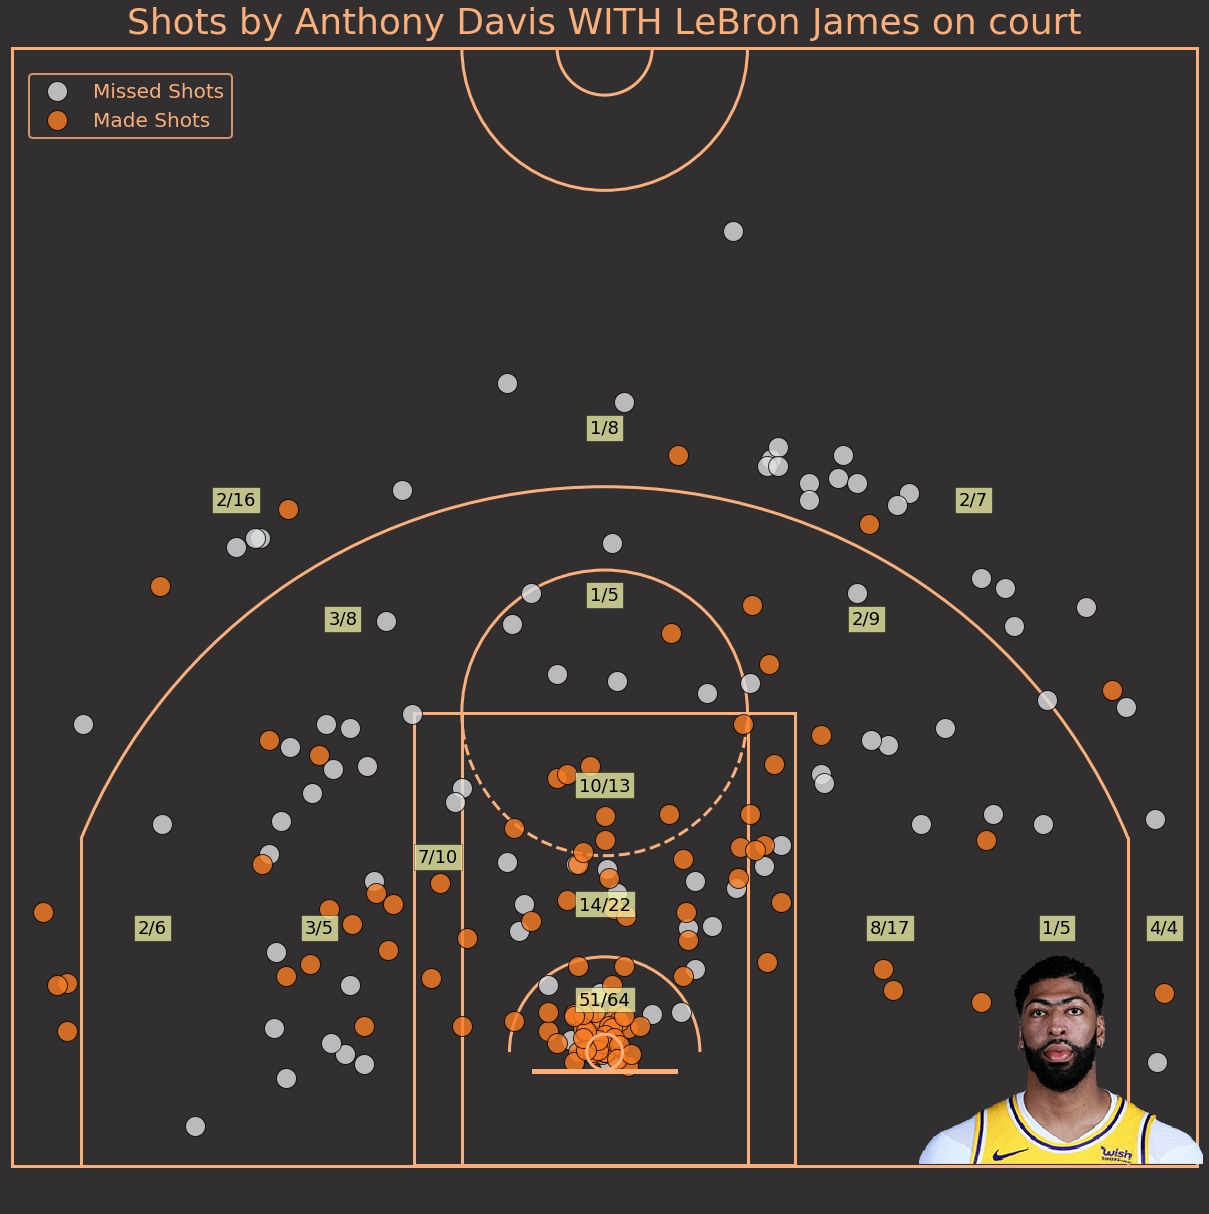

In [176]:
plot_raw_shotchart_dark(data_frame=shot_df_ad_lebron, title="Shots by Anthony Davis WITH LeBron James on court", plot_attempts=True, plot_image=True)

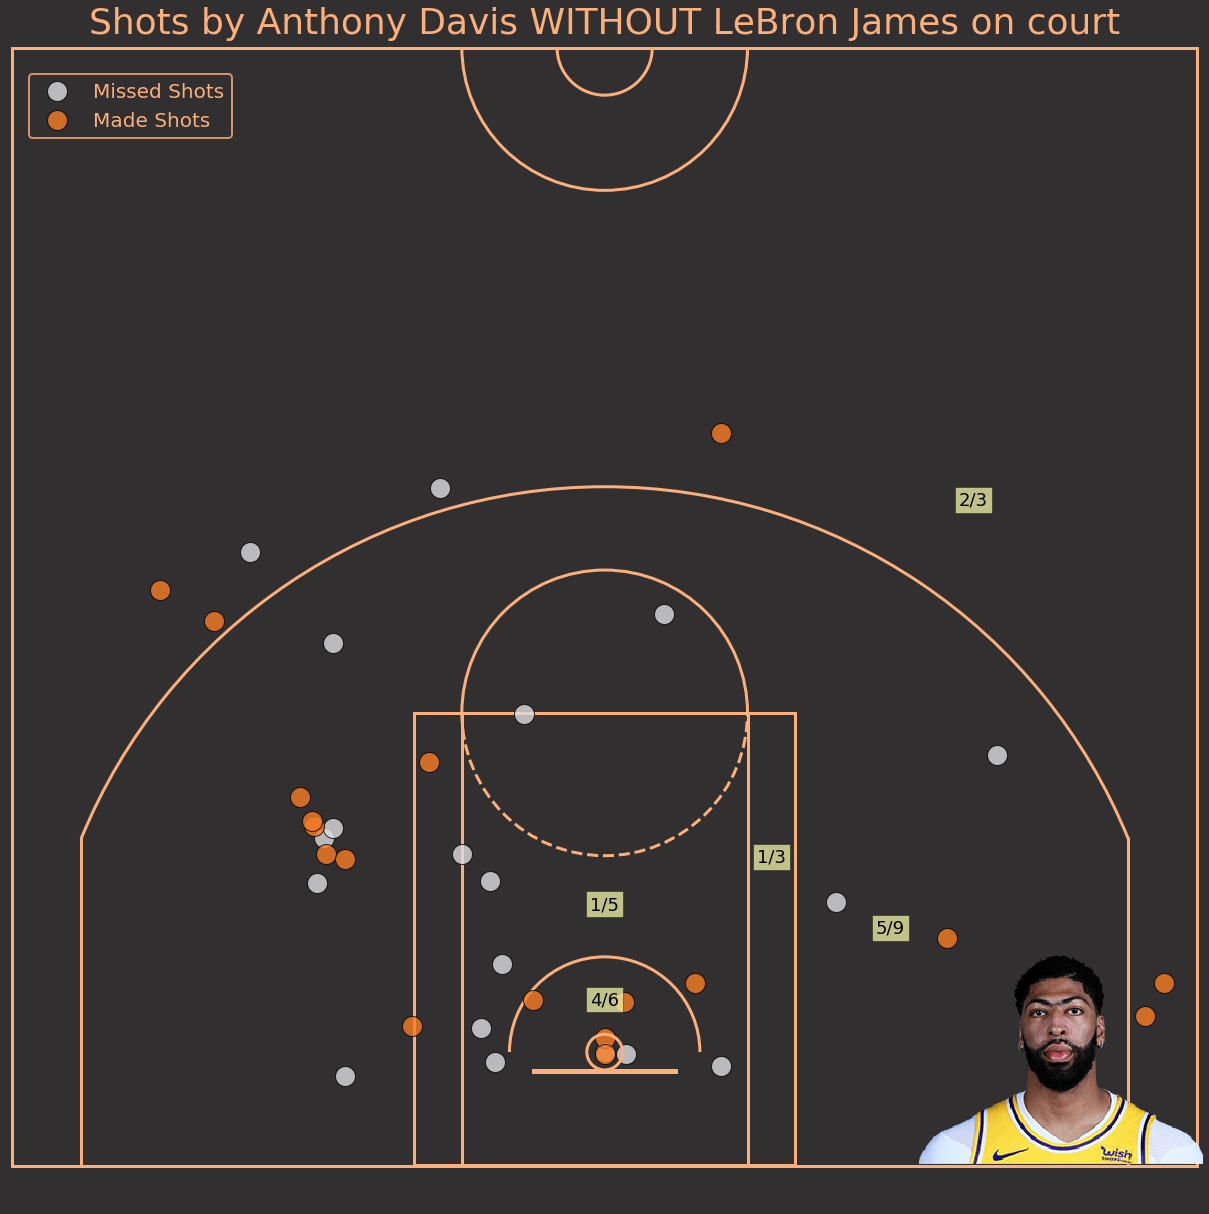

In [175]:
plot_raw_shotchart_dark(data_frame=shot_df_ad_no_lebron, title="Shots by Anthony Davis WITHOUT LeBron James on court", plot_attempts=True, plot_image=True)

### TEST

In [225]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [229]:
player_stats = LeagueDashPlayerStats(season='2019-20', per_mode_detailed='PerGame').get_data_frames()[0]

In [231]:
top_players = player_stats.sort_values(by='PTS', ascending=False).iloc[:30]

In [251]:
top_players = top_players.loc[top_players.GP > 40]

In [245]:
season = '2019-20'
last_df = pd.read_csv(f'pbp_data/{season}.csv')
last_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in last_df.GAME_ID.astype(str)]
last_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in last_df.PCTIMESTRING.tolist()]

In [255]:
strings = []

mappings = {}

for index in range(len(top_players)):
    player_id = top_players.iloc[index].PLAYER_ID
    last_schedule = get_game_schedule_for_season(season=season)

    player_subs = get_player_substitutions(pbp_df=last_df, player_id=player_id, game_schedule_df=last_schedule)

    player_on, player_off = get_on_off_data(player_id=player_id, season=season, player_subs=player_subs, full_df=last_df)

    made_shots, all_shots = get_shots(player_on=player_on)
    out_string = print_efficiency(made_shots, all_shots, player_name=top_players.iloc[index].PLAYER_NAME)
    strings.append(out_string)
    mappings[player_id] = {
        'made': dict(made_shots),
        'all': dict(all_shots)
    }



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:06<00:00, 11.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.69it/s]

 21%|█████████████████████████████████████                                                                                                                                          | 14/66 [00:01<00:04, 11.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:06<00:00, 10.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.89it/s]

 25%|████████████████████████████████████████████▍                                                                                                                                  | 16/63 [00:01<00:05,  8.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:05<00:00, 10.83it/s]

  0%|                                                                                                                                                                                        | 0/57 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:06<00:00,  9.08it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 45/57 [00:04<00:01, 10.75it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 10.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:05<00:00, 11.02it/s]

  0%|                                                                                                                                                                                        | 0/60 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 48/67 [00:05<00:02,  9.28it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:07<00:00,  8.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 65/69 [00:08<00:00,  7.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:08<00:00,  7.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00, 10.03it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 40/66 [00:04<00:03,  8.40it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:07<00:00,  8.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:05<00:00,  8.71it/s]

 16%|███████████████████████████▌                                                                                                                                                    | 8/51 [00:00<00:05,  8.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.78it/s]

  3%|█████                                                                                                                                                                           | 2/70 [00:00<00:05, 11.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  9.79it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 47/68 [00:04<00:02,  8.41it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:06<00:00, 10.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00,  9.02it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25/41 [00:02<00:01,  9.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  9.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 10.45it/s]

  5%|████████▌                                                                                                                                                                       | 3/62 [00:00<00:05, 10.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 47/65 [00:04<00:01, 10.42it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:06<00:00, 10.45it/s]


In [271]:
mappings_copy = {}

for key in mappings:
    made_dict = {}
    all_dict = {}
    for inner_key in mappings[key]['made']:
        made_dict[int(inner_key)] = mappings[key]['made'][inner_key]
        all_dict[int(inner_key)] = mappings[key]['all'][inner_key]
    mappings_copy[int(key)] = {
        'made': made_dict,
        'all': all_dict
    }
    

In [272]:
mappings_copy

{201935: {'made': {1: 53,
   2: 79,
   7: 73,
   5: 61,
   4: 78,
   3: 84,
   6: 63,
   9: 60,
   10: 30,
   8: 71,
   12: 11,
   11: 9},
  'all': {1: 142,
   2: 162,
   7: 163,
   5: 158,
   4: 162,
   3: 161,
   6: 150,
   9: 135,
   10: 75,
   8: 154,
   12: 28,
   11: 24}},
 203078: {'made': {3: 70,
   10: 22,
   7: 72,
   2: 47,
   6: 56,
   8: 61,
   12: 10,
   1: 73,
   4: 73,
   5: 61,
   11: 12,
   9: 36},
  'all': {3: 161,
   10: 54,
   7: 141,
   2: 111,
   6: 135,
   8: 125,
   12: 17,
   1: 157,
   4: 142,
   5: 141,
   11: 25,
   9: 94}},
 203081: {'made': {4: 69,
   7: 58,
   1: 51,
   2: 77,
   5: 55,
   10: 29,
   11: 36,
   3: 75,
   8: 46,
   6: 52,
   9: 48,
   12: 28},
  'all': {4: 147,
   7: 112,
   1: 127,
   2: 156,
   5: 118,
   10: 78,
   11: 78,
   3: 151,
   8: 105,
   6: 108,
   9: 98,
   12: 71}},
 1629027: {'made': {2: 77,
   5: 50,
   7: 40,
   1: 83,
   4: 60,
   6: 59,
   11: 13,
   12: 7,
   8: 38,
   3: 81,
   9: 23,
   10: 15},
  'all': {2: 172,
  

In [273]:
with open('2019_20_top_summary.json', 'w') as f:
    json.dump(mappings_copy, f)

In [250]:
for string in strings:
    print(string)
    print()

Efficiency when James Harden is 0-3 minutes on court: 216/465 (46.5%)
Efficiency when James Harden is 3-6 minutes on court: 202/470 (43.0%)
Efficiency when James Harden is 6-9 minutes on court: 204/452 (45.1%)
Efficiency when James Harden is 9-12 minutes on court: 50/127 (39.4%)

Efficiency when Bradley Beal is 0-3 minutes on court: 190/429 (44.3%)
Efficiency when Bradley Beal is 3-6 minutes on court: 190/418 (45.5%)
Efficiency when Bradley Beal is 6-9 minutes on court: 169/360 (46.9%)
Efficiency when Bradley Beal is 9-12 minutes on court: 44/96 (45.8%)

Efficiency when Damian Lillard is 0-3 minutes on court: 203/434 (46.8%)
Efficiency when Damian Lillard is 3-6 minutes on court: 176/373 (47.2%)
Efficiency when Damian Lillard is 6-9 minutes on court: 152/315 (48.3%)
Efficiency when Damian Lillard is 9-12 minutes on court: 93/227 (41.0%)

Efficiency when Trae Young is 0-3 minutes on court: 241/516 (46.7%)
Efficiency when Trae Young is 3-6 minutes on court: 169/382 (44.2%)
Efficiency whe